In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#there is data?
    #if not:
        #download data
    #yes:
        #check for update
        #there is data more updated:
            #if yes:
                #download uploaded data
#read data

In [2]:
#read data
data = pd.read_csv('data/subwayOriginalData.csv',sep=';')
#select neded columns
data = data[['FR1_FECHA','FR1_LINEA','FR1_VIAC1','FR1_SALC1','FR1_VIAC2','FR1_SALC2']]
data.columns = ['date','line','dispached1','deparTime1','dispached2','deparTime2']

#error in data for a especific date
data.date = data.date.str.replace('/07//07/16','07/07/2016')
data.head()

#separate data frame into the two terminals

#select rows and columns  corresponding to terminal 1 
t1 = data[['date','line','deparTime1']][data.dispached1=='S'].copy()
t1['terminal']=1


#select rows and columns  corresponding to terminal 1 
t2 = data[['date','line','deparTime2']][data.dispached2=='S'].copy()
t2['terminal']=2

#set same names and add by cell
t1.columns=['date','line','deparTime','terminal']
t2.columns=['date','line','deparTime','terminal']
cleanData = t1.append(t2,ignore_index=True)


#create date
cleanData['depart']=cleanData.date  + ' ' + cleanData.deparTime

#sort prior to lag
cleanData = cleanData.sort_values(['terminal','line','depart'])

pd.crosstab(cleanData.line,cleanData.terminal)

#create a lag vector
cleanData['departLag'] = cleanData.depart.shift(1)

/home/pipe/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cleanData.head()

,date,line,deparTime,terminal,depart,departLag
229,01/01/2015,A,07:52:00,1,01/01/2015 07:52:00,NaN
230,01/01/2015,A,08:00:00,1,01/01/2015 08:00:00,01/01/2015 07:52:00
231,01/01/2015,A,08:09:20,1,01/01/2015 08:09:20,01/01/2015 08:00:00
232,01/01/2015,A,08:18:40,1,01/01/2015 08:18:40,01/01/2015 08:09:20
233,01/01/2015,A,08:28:00,1,01/01/2015 08:28:00,01/01/2015 08:18:40


In [4]:
#reindex
cleanData.index = range(len(cleanData.index))
#remove first row
cleanData = cleanData.ix[1:]

pd.crosstab(cleanData.line,cleanData.terminal)

terminal,1,2
line,,
A,105336,106857
B,114150,116020
C,129003,129316
D,124017,126561
E,81131,82587
H,75259,75683
P,44610,0


In [5]:
#set date to dates format
cleanData['depart']=cleanData.depart.map(lambda x: pd.to_datetime(x, format = '%d/%m/%Y %H:%M:%S')) #tengo que especificar que es %d/%m/%Y %H:%M:%S 
cleanData['departLag']=cleanData.departLag.map(lambda x: pd.to_datetime(x, format = '%d/%m/%Y %H:%M:%S'))
cleanData.head()

,date,line,deparTime,terminal,depart,departLag
1,01/01/2015,A,08:00:00,1,2015-01-01 08:00:00,2015-01-01 07:52:00
2,01/01/2015,A,08:09:20,1,2015-01-01 08:09:20,2015-01-01 08:00:00
3,01/01/2015,A,08:18:40,1,2015-01-01 08:18:40,2015-01-01 08:09:20
4,01/01/2015,A,08:28:00,1,2015-01-01 08:28:00,2015-01-01 08:18:40
5,01/01/2015,A,08:37:20,1,2015-01-01 08:37:20,2015-01-01 08:28:00


In [6]:
#get weekdays for both depart and lag
cleanData['departDay'] = cleanData.depart.map(lambda x: x.strftime('%A'))
cleanData['departLagDay'] = cleanData.departLag.map(lambda x: x.strftime('%A'))
cleanData['month']=cleanData.depart.map(lambda x: x.strftime('%Y %m'))

#remove lags between diferent days
cleanData = cleanData[cleanData.departDay == cleanData.departLagDay]

cleanData.head()

,date,line,deparTime,terminal,depart,departLag,departDay,departLagDay,month
1,01/01/2015,A,08:00:00,1,2015-01-01 08:00:00,2015-01-01 07:52:00,Thursday,Thursday,2015 01
2,01/01/2015,A,08:09:20,1,2015-01-01 08:09:20,2015-01-01 08:00:00,Thursday,Thursday,2015 01
3,01/01/2015,A,08:18:40,1,2015-01-01 08:18:40,2015-01-01 08:09:20,Thursday,Thursday,2015 01
4,01/01/2015,A,08:28:00,1,2015-01-01 08:28:00,2015-01-01 08:18:40,Thursday,Thursday,2015 01
5,01/01/2015,A,08:37:20,1,2015-01-01 08:37:20,2015-01-01 08:28:00,Thursday,Thursday,2015 01


In [7]:
#set the gap between each train departure

#ACA NO HAY QUE DEJARLO EN MINUTO SY SEGUNDOS???????? OJO QUE ESTA EN INT

cleanData['gap'] = (cleanData.depart - cleanData.departLag)
#set outliers as those extreme 10% 
outliers = cleanData.gap.quantile([.10,.90])
vectorOut = (cleanData.gap > outliers.iloc[0]) & (cleanData.gap < outliers.iloc[1])
cleanData = cleanData[vectorOut]
cleanData.head()

,date,line,deparTime,terminal,depart,departLag,departDay,departLagDay,month,gap
1,01/01/2015,A,08:00:00,1,2015-01-01 08:00:00,2015-01-01 07:52:00,Thursday,Thursday,2015 01,00:08:00
90,01/01/2015,A,22:08:00,1,2015-01-01 22:08:00,2015-01-01 22:00:00,Thursday,Thursday,2015 01,00:08:00
92,01/01/2016,A,08:00:00,1,2016-01-01 08:00:00,2016-01-01 07:52:00,Friday,Friday,2016 01,00:08:00
93,01/01/2016,A,08:08:00,1,2016-01-01 08:08:00,2016-01-01 08:00:00,Friday,Friday,2016 01,00:08:00
94,01/01/2016,A,08:16:00,1,2016-01-01 08:16:00,2016-01-01 08:08:00,Friday,Friday,2016 01,00:08:00


In [8]:
cleanData['gapInt'] = cleanData.gap / np.timedelta64(1, 'm')
cleanData['hourDepart'] = cleanData.departLag.map(lambda x: x.hour)

In [9]:
#crear rushAftern booleano
cleanData['rushMorn'] = (cleanData['hourDepart'] == 8) | (cleanData['hourDepart'] == 9)
cleanData['rushAftern'] = (cleanData['hourDepart'] == 18) | (cleanData['hourDepart'] == 19)
cleanData.head()
#crear rushMorn


,date,line,deparTime,terminal,depart,departLag,departDay,departLagDay,month,gap,gapInt,hourDepart,rushMorn,rushAftern
1,01/01/2015,A,08:00:00,1,2015-01-01 08:00:00,2015-01-01 07:52:00,Thursday,Thursday,2015 01,00:08:00,8.0,7,False,False
90,01/01/2015,A,22:08:00,1,2015-01-01 22:08:00,2015-01-01 22:00:00,Thursday,Thursday,2015 01,00:08:00,8.0,22,False,False
92,01/01/2016,A,08:00:00,1,2016-01-01 08:00:00,2016-01-01 07:52:00,Friday,Friday,2016 01,00:08:00,8.0,7,False,False
93,01/01/2016,A,08:08:00,1,2016-01-01 08:08:00,2016-01-01 08:00:00,Friday,Friday,2016 01,00:08:00,8.0,8,True,False
94,01/01/2016,A,08:16:00,1,2016-01-01 08:16:00,2016-01-01 08:08:00,Friday,Friday,2016 01,00:08:00,8.0,8,True,False


In [13]:
cleanData.drop(['date','deparTime','depart','departLag','departLagDay','gap'], axis = 1,inplace=True)
cleanData.head()


,line,terminal,departDay,month,gapInt,hourDepart,rushMorn,rushAftern
1,A,1,Thursday,2015 01,8.0,7,False,False
90,A,1,Thursday,2015 01,8.0,22,False,False
92,A,1,Friday,2016 01,8.0,7,False,False
93,A,1,Friday,2016 01,8.0,8,True,False
94,A,1,Friday,2016 01,8.0,8,True,False


In [19]:
weekendDay = (cleanData.departDay == 'Saturday') | (cleanData.departDay == 'Sunday' )
cleanData = cleanData.loc[~weekendDay]

OrderedDict([('gapInt',
              <matplotlib.axes._subplots.AxesSubplot at 0x7f68b51e9c50>)])

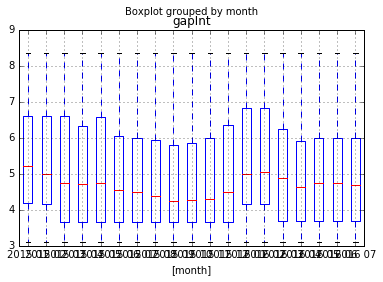

In [21]:
cleanData.boxplot(column='gapInt',by=['month'], return_type='axes')

In [24]:
monthlyDep = cleanData.groupby(['month','line','terminal']).describe()
#is a data frame with una column, index are months
#monthlyDep.mean()

#.loc['2015 01'], .loc['A'] .loc['1']


In [29]:
cleanData.head()

,line,terminal,departDay,month,gapInt,hourDepart,rushMorn,rushAftern
1,A,1,Thursday,2015 01,8.0,7,False,False
90,A,1,Thursday,2015 01,8.0,22,False,False
92,A,1,Friday,2016 01,8.0,7,False,False
93,A,1,Friday,2016 01,8.0,8,True,False
94,A,1,Friday,2016 01,8.0,8,True,False


In [100]:
#plot de todas las lineas con plot box historico pero de terminal 1 a la mañana y terminal 2 a la tarde
lines = cleanData.line.unique()
terminals = cleanData.terminal.unique()
months = np.sort(cleanData.month.unique())
colors = ['lightskyblue','red','navy','forestgreen','darkviolet','yellow','brown',]
#RESOLVER ESTO DEL LOOP Y BOXPLOT

pd.crosstab(cleanData.line,cleanData.terminal)




terminal,1,2
line,,
A,81860,82476
B,78690,80045
C,87635,88055
D,70464,71290
E,49505,48454
H,49086,49615
P,8942,0


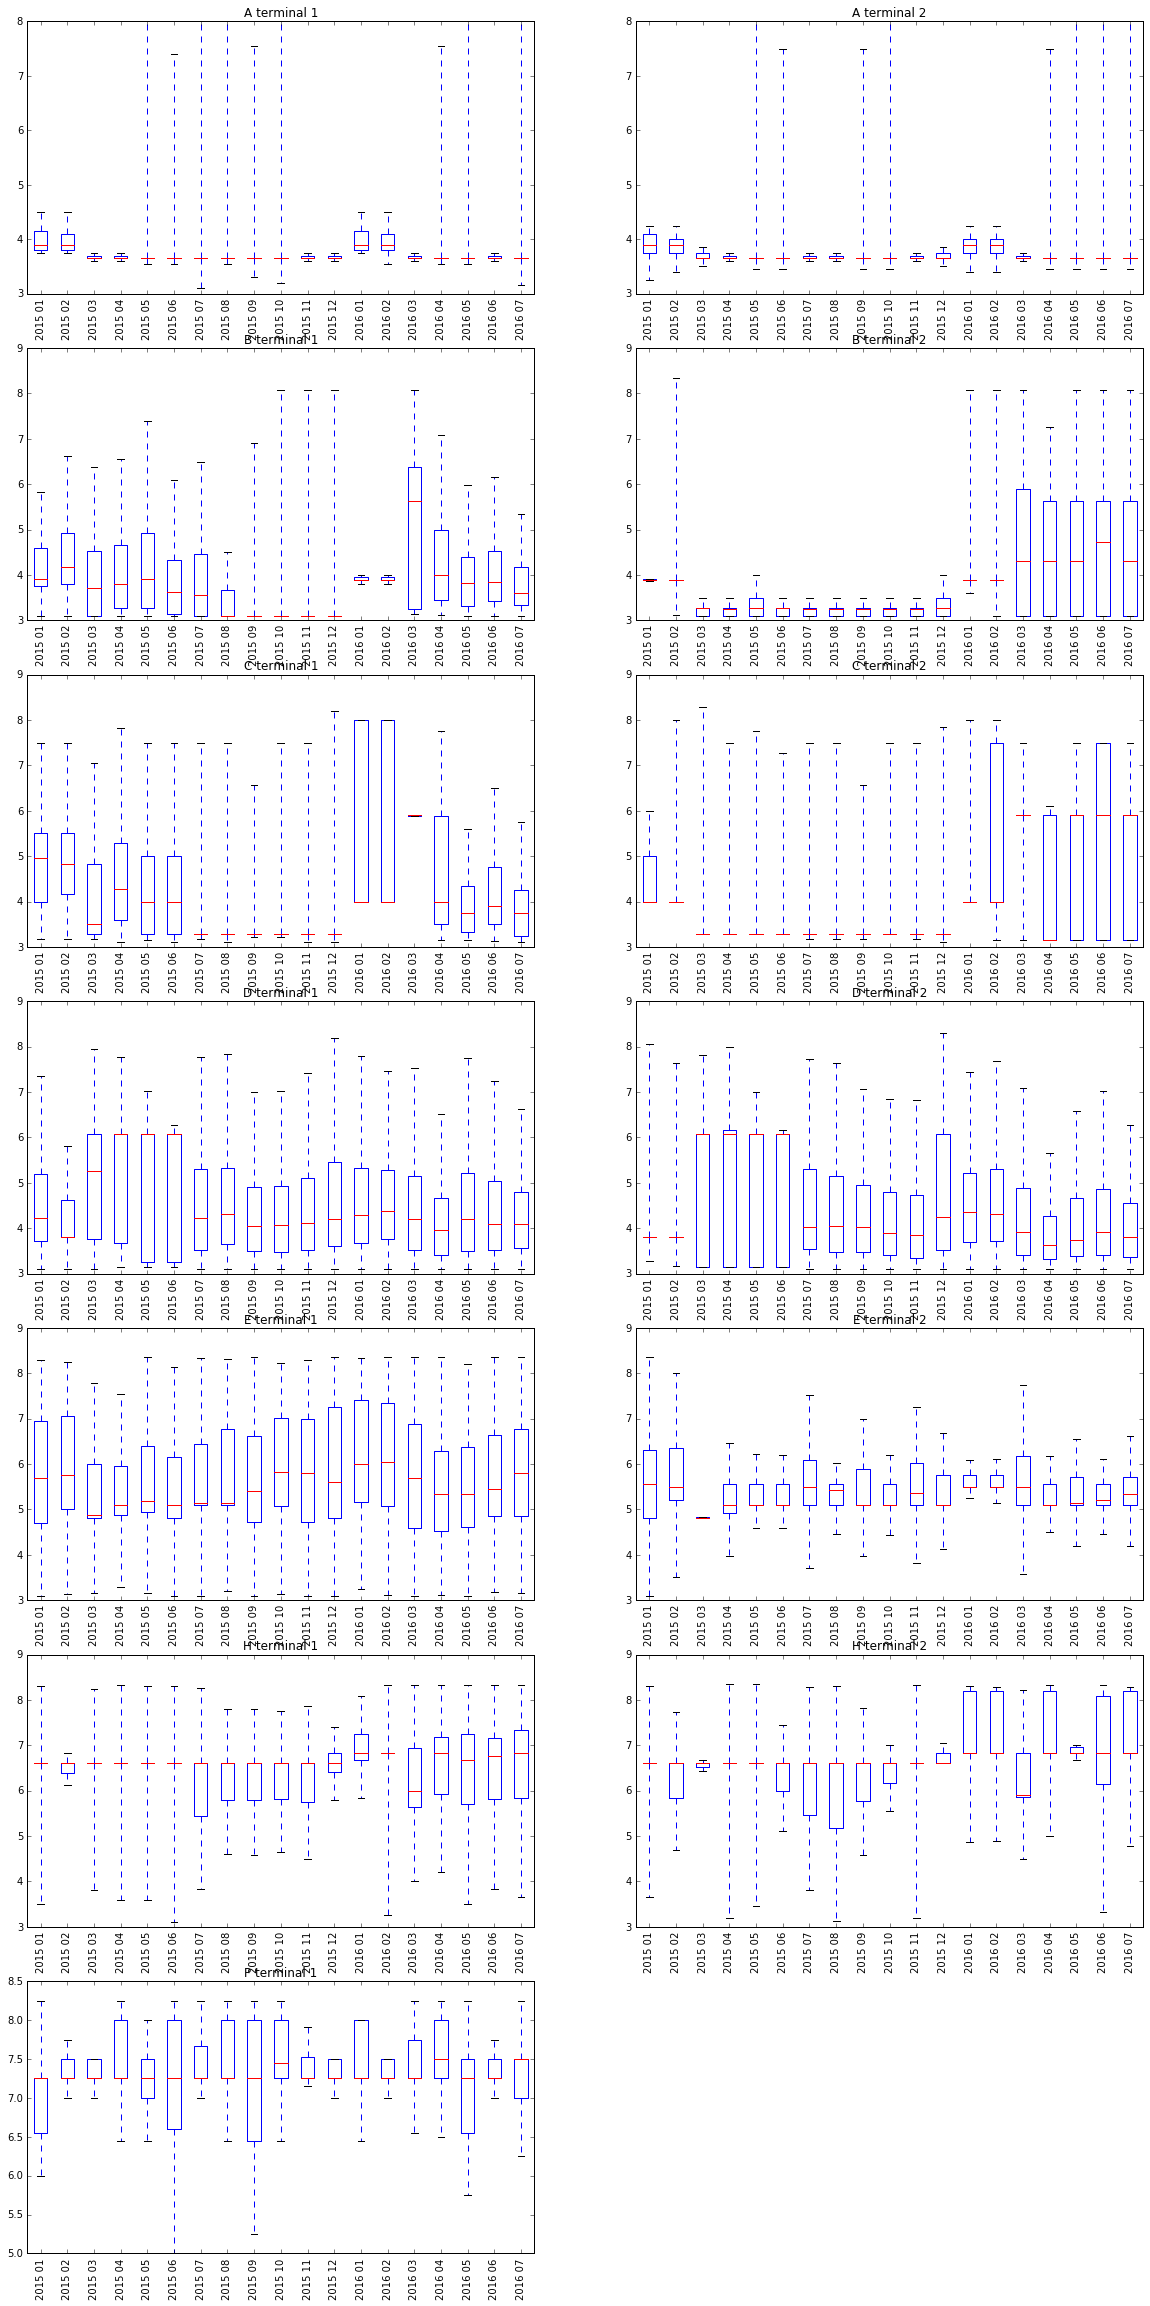

In [109]:
fig = plt.figure(figsize=(20,40))
plotId = 1
for lineId in range(len(lines)):
    
    for i in [1,2]:
    #terminal 1 es de maniana, periferica. P no tiene 2

        line = lines[lineId]
        color = colors[lineId]
        terminal = i
        monthList = []

        for month in months:
            selection = (cleanData.line == line) & (cleanData.terminal == terminal) & (cleanData.month == month)
            #PARA LA C QUE NO HAYA RUSH
            if i == 1:
                selection = selection & cleanData.rushMorn
            else:
                selection = selection & cleanData.rushAftern

            monthList.append(cleanData.gapInt.loc[selection])

        if line == 'P' and terminal == 2:
            break
        
        ax = fig.add_subplot(7, 2, plotId)
        ax.boxplot(monthList,0, '')
        ax.set_xticklabels(months, rotation='vertical')
        ax.set_title(line + ' terminal ' + str(i))
        #ax.set_facecolor(color)
        plotId += 1

In [84]:
7 * 8

56

In [98]:
plt.boxplot(range(20),fill='lightskyblue')

TypeError: boxplot() got an unexpected keyword argument 'fill'

AttributeError: 'list' object has no attribute 'set_facecolor'

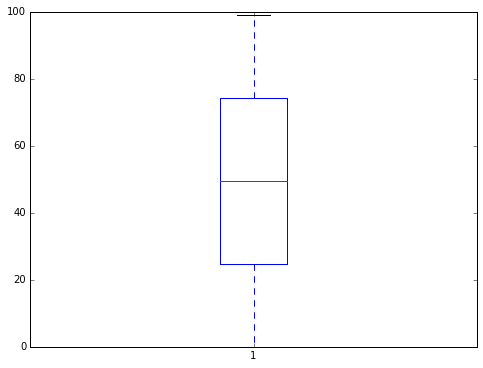

In [108]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, plotId)
ax.boxplot(range(100),0, '')
#plt.setp(ax['boxes'], color='black')
#plt.setp(ax['whiskers'], color='black')
#plt.setp(ax['fliers'], color='red', marker='+')

box = plt.boxplot(range(100), patch_artist=True)
box['boxes'].set_facecolor('red')

                  
#http://stackoverflow.com/questions/20289091/python-matplotlib-filled-boxplotsS